# Weather relation to cities coordinates

### Observations

1. Only temperature seems to be moderately affected by the latitude.
2. Wind speed, humidity and cloudiness seem to be unaffected by the latitude.
3. Temperature goes down as the latitude moves away from the Equator.

## Dependecies and configuration

In [19]:
# Import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

from scipy import stats
from datetime import date, datetime

# Import keys.
from api_keys import weather_api_key
from api_keys import g_key

# Dataset location.
cities_json_file_path = os.path.join('Resources', 'city.list.json')

# Output file for 1000 unique cities (is good sample out of 200K cities)
one_thousand_unique_cities_path = os.path.join('output', 'one_thousand_unique_cities.csv')

# Weather API configuration
weather_api_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Base query URL
base_weather_data_for_a_city_url = f"{weather_api_url}appid={weather_api_key}&units={units}"


### Functions

In [20]:
# Get middle point
def get_middle_point(a_series):
    middle = ((a_series.max() + a_series.min() ) / 2)
    return middle

# Print scatter plot and save the plot as an image
def print_scatter_plot_with_regression_equation(x_series, y_series, marker, title, y_label, x_label, file_name, regress_values = None, line_eq = None):
    
    # Build scatter plot
    plt.scatter(x_series, y_series, marker = marker)
    
    if regress_values is not None:
        # Build line equation and annotate it to the scatter plot
        plt.plot(x_series, regress_values, "r-")
        plt.annotate(line_eq, (get_middle_point(x_series), get_middle_point(y_series)), fontsize = 15, color = "red")
    
    # Incorporate the other graph properties
    plt.title(f"{title} - {date.today()}")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.grid(True)
    
    # Save the figure
    plt.savefig(f"output/{file_name}-{date.today()}.png")
    
    # Show plot
    plt.show()

# Perform linear regression. Return regressed values, the linear equation and the r-value
def linear_regression_with_equation(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    # Print r square value
    print(f"The r-squared is: {rvalue**2}")
    
    return regress_values, line_equation

## Load dataset of cities and prepare sample dataframe

In [21]:
# Read cities dataset.
cities_df = pd.read_json(cities_json_file_path)

cities_coordinates = pd.json_normalize(cities_df['coord'])

cities_df = cities_df.merge(cities_coordinates, left_index = True, right_index = True) 
cities_df.drop(columns = ['coord'], inplace = True)

total_cities_count = cities_df['id'].unique()
print(f'Number of cities loaded: {len(total_cities_count)}')

Number of cities loaded: 209579


### Preparing sample of cities dataframe

In [22]:
# Divide cities in four groups.
# Each group will be made using the main imaginary lines dividing the Earth (the Prime meridian and the Equator).

# Cities in the first quadrant (longitude is negative and latitude is positive)
first_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] > 0)
first_quadrant_cities_df = cities_df.loc[first_quadrant_cities]

# Cities in the second quadrant (both longitude and latitude are positive)
second_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] > 0)
second_quadrant_cities_df = cities_df.loc[second_quadrant_cities]

# Cities in the third quadrant (both longitude and latitude are negative)
third_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] < 0)
third_quadrant_cities_df = cities_df.loc[third_quadrant_cities]

# Cities in the fourth quadrant (longitude is positive and latitude is negative)
fourth_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] < 0)
fourth_quadrant_cities_df = cities_df.loc[fourth_quadrant_cities]

# Get 1000 random unique cities in the world
temp_df = first_quadrant_cities_df.sample(n = 250)
one_thousand_cities = pd.DataFrame(temp_df)

temp_df = second_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = third_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = fourth_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

one_thousand_cities.reset_index(inplace = True)
one_thousand_cities = one_thousand_cities.drop(columns = ['index'])
one_thousand_cities.rename(columns={'id': 'city_id'}, inplace = True)
one_thousand_cities.rename(columns={'name': 'city_name'}, inplace = True)
one_thousand_cities = one_thousand_cities[['city_id', 'city_name', 'state', 'country', 'lat', 'lon']]

sample_cities_count = one_thousand_cities['city_id'].unique()
print(f'Number of sample cities: {len(sample_cities_count)}')

one_thousand_cities.head()

Number of sample cities: 1000


,city_id,city_name,state,country,lat,lon
0,2416969,Nzérékoré,,GN,7.756240,-8.817900
1,6183141,Wingham,,CA,43.887932,-81.311447
2,3489781,Liguanea,,JM,18.017611,-76.764351
3,2738660,Jesufrei,,PT,41.450001,-8.500000
4,6357857,Campisábalos,,ES,41.260750,-3.147240


## Start calculations and building plots

In [23]:
# Get weather data for all 1000 unique cities

counter = 0

print("Start data request...")

# Loop through the list of cities and perform a request for data on each
for index, city in one_thousand_cities.iterrows():
    id_param = f"&id={city['city_id']}"
    counter += 1
    
    print(f"{counter} - Getting weather data for: {city['city_id']} - {city['city_name']}, {city['country']} ... ")
    try:
        response = requests.get(base_weather_data_for_a_city_url + id_param).json()
        print(f"Data received.")
        
        one_thousand_cities.loc[index, 'temperature'] = response['main']['temp']
        one_thousand_cities.loc[index, 'humidity'] = response['main']['humidity']
        one_thousand_cities.loc[index, 'cloudiness'] = response['clouds']['all']
        one_thousand_cities.loc[index, 'wind_speed'] = response['wind']['speed']
        one_thousand_cities.loc[index, 'weather_condition'] = response['weather'][0]['main']
        one_thousand_cities.loc[index, 'weather_condition_desc'] = response['weather'][0]['description']
    except:
        print(f"There was an error retrieving this city weather data: {city['city_id']} - {city['city_name']}, {city['country']}")
    
    one_thousand_cities.loc[index, 'datetime'] = datetime.now()

print("Data request completed.")

one_thousand_cities.dropna(subset = ['temperature'], inplace = True)

one_thousand_cities.info()


Start data request...
1 - Getting weather data for: 2416969 - Nzérékoré, GN ... 
Data received.
2 - Getting weather data for: 6183141 - Wingham, CA ... 
Data received.
3 - Getting weather data for: 3489781 - Liguanea, JM ... 
Data received.
4 - Getting weather data for: 2738660 - Jesufrei, PT ... 
Data received.
5 - Getting weather data for: 6357857 - Campisábalos, ES ... 
Data received.
6 - Getting weather data for: 2644795 - Law, GB ... 
Data received.
7 - Getting weather data for: 5846893 - Haines Borough, US ... 
Data received.
8 - Getting weather data for: 4704482 - Lake Dallas, US ... 
Data received.
9 - Getting weather data for: 4870716 - Park View, US ... 
Data received.
10 - Getting weather data for: 2509603 - Villa del Río, ES ... 
Data received.
11 - Getting weather data for: 4011469 - Puebla, MX ... 
Data received.
12 - Getting weather data for: 4566706 - Pico Alalaya, PR ... 
Data received.
13 - Getting weather data for: 7297121 - Whixall, GB ... 
Data received.
14 - Getti

Data received.
108 - Getting weather data for: 5896584 - Beaux-Rivages--Lac-des-Écorces--Val-Barrette, CA ... 
Data received.
109 - Getting weather data for: 5101090 - Mercer County, US ... 
Data received.
110 - Getting weather data for: 2984456 - Rancoudray, FR ... 
Data received.
111 - Getting weather data for: 2653307 - Chasetown, GB ... 
Data received.
112 - Getting weather data for: 5975322 - Hillside, CA ... 
Data received.
113 - Getting weather data for: 3518387 - San Mateo Atenco, MX ... 
Data received.
114 - Getting weather data for: 2639844 - Puriton, GB ... 
Data received.
115 - Getting weather data for: 8013996 - Mundão, PT ... 
Data received.
116 - Getting weather data for: 5928517 - Cottam, CA ... 
Data received.
117 - Getting weather data for: 2513932 - Mengabril, ES ... 
Data received.
118 - Getting weather data for: 3516234 - Tatahuicapan, MX ... 
Data received.
119 - Getting weather data for: 4540403 - Konawa, US ... 
Data received.
120 - Getting weather data for: 412

Data received.
213 - Getting weather data for: 4419094 - Booneville, US ... 
Data received.
214 - Getting weather data for: 7871418 - Barrio El Bao, ES ... 
Data received.
215 - Getting weather data for: 4877138 - Spencer, US ... 
Data received.
216 - Getting weather data for: 4068546 - Hunter, US ... 
Data received.
217 - Getting weather data for: 4474627 - La Grange, US ... 
Data received.
218 - Getting weather data for: 2735080 - Rio Torto, PT ... 
Data received.
219 - Getting weather data for: 3519396 - San Fernando, MX ... 
Data received.
220 - Getting weather data for: 4184813 - Broxton, US ... 
Data received.
221 - Getting weather data for: 2974355 - Solférino, FR ... 
Data received.
222 - Getting weather data for: 5234861 - Chittenden County, US ... 
Data received.
223 - Getting weather data for: 2646327 - Hyde, GB ... 
Data received.
224 - Getting weather data for: 2990968 - Arrondissement de Nantes, FR ... 
Data received.
225 - Getting weather data for: 4858952 - Granger, US 

Data received.
321 - Getting weather data for: 3035418 - Bagnères-de-Bigorre, FR ... 
Data received.
322 - Getting weather data for: 6559325 - Wielen, DE ... 
Data received.
323 - Getting weather data for: 2773646 - Köttmannsdorf, AT ... 
Data received.
324 - Getting weather data for: 1799919 - Nanling, CN ... 
Data received.
325 - Getting weather data for: 3038230 - Alençon, FR ... 
Data received.
326 - Getting weather data for: 617372 - Şoldăneşti, MD ... 
Data received.
327 - Getting weather data for: 3182632 - Avigliano Umbro, IT ... 
Data received.
328 - Getting weather data for: 734643 - Pylaía, GR ... 
Data received.
329 - Getting weather data for: 6535934 - Terlano, IT ... 
Data received.
330 - Getting weather data for: 1848633 - Yamazakichō-nakabirose, JP ... 
Data received.
331 - Getting weather data for: 2789834 - Onhaye, BE ... 
Data received.
332 - Getting weather data for: 1817846 - Xilin, CN ... 
Data received.
333 - Getting weather data for: 2494610 - Hamma Bouziane, DZ

Data received.
428 - Getting weather data for: 2661339 - Buix, CH ... 
Data received.
429 - Getting weather data for: 6451980 - Sceaux, FR ... 
Data received.
430 - Getting weather data for: 2939167 - Damme, DE ... 
Data received.
431 - Getting weather data for: 680520 - Coteana, RO ... 
Data received.
432 - Getting weather data for: 7872612 - Ehenbichl, AT ... 
Data received.
433 - Getting weather data for: 641055 - Polvijärvi, FI ... 
Data received.
434 - Getting weather data for: 613226 - Lent’ekhi, GE ... 
Data received.
435 - Getting weather data for: 2785879 - Sur le Stockeu, BE ... 
Data received.
436 - Getting weather data for: 2937531 - Diefenbach, DE ... 
Data received.
437 - Getting weather data for: 2111543 - Ōhira, JP ... 
Data received.
438 - Getting weather data for: 786395 - Ravni Topolovac, RS ... 
Data received.
439 - Getting weather data for: 597188 - Mazeikiai, LT ... 
Data received.
440 - Getting weather data for: 2779082 - Fußach, AT ... 
Data received.
441 - Gett

Data received.
535 - Getting weather data for: 4034778 - Sigavé, WF ... 
Data received.
536 - Getting weather data for: 3866035 - Alto Río Senguer, AR ... 
Data received.
537 - Getting weather data for: 3451262 - Rio Bom, BR ... 
Data received.
538 - Getting weather data for: 3387242 - Solonópole, BR ... 
Data received.
539 - Getting weather data for: 3919720 - Colquechaca, BO ... 
Data received.
540 - Getting weather data for: 3445140 - Vicente Dutra, BR ... 
Data received.
541 - Getting weather data for: 3946083 - Callao, PE ... 
Data received.
542 - Getting weather data for: 3438755 - Cecilio Baez, PY ... 
Data received.
543 - Getting weather data for: 3441074 - Piriapolis, UY ... 
Data received.
544 - Getting weather data for: 3451095 - Rio Piracicaba, BR ... 
Data received.
545 - Getting weather data for: 3397982 - Itaiçaba, BR ... 
Data received.
546 - Getting weather data for: 3652462 - Quito, EC ... 
Data received.
547 - Getting weather data for: 3472397 - Alvorada do Sul, BR .

Data received.
640 - Getting weather data for: 3867291 - Filadelfia, PY ... 
Data received.
641 - Getting weather data for: 3954288 - Mosoc Cancha, PE ... 
Data received.
642 - Getting weather data for: 3466933 - Carlos Barbosa, BR ... 
Data received.
643 - Getting weather data for: 3855152 - Gaviotas, AR ... 
Data received.
644 - Getting weather data for: 3456847 - Monte Castelo, BR ... 
Data received.
645 - Getting weather data for: 3863377 - Caleufú, AR ... 
Data received.
646 - Getting weather data for: 3437927 - Itapé, PY ... 
Data received.
647 - Getting weather data for: 3839063 - Ricardo Gaviña, AR ... 
Data received.
648 - Getting weather data for: 3843802 - Departamento de Monteros, AR ... 
Data received.
649 - Getting weather data for: 6322174 - Campos do Jordão, BR ... 
Data received.
650 - Getting weather data for: 3437062 - San Juan del Paraná, PY ... 
Data received.
651 - Getting weather data for: 6322112 - Arujá, BR ... 
Data received.
652 - Getting weather data for: 39

Data received.
745 - Getting weather data for: 3435269 - Departamento de Concepción, AR ... 
Data received.
746 - Getting weather data for: 3466993 - Caarapó, BR ... 
Data received.
747 - Getting weather data for: 3887788 - Hualañe, CL ... 
Data received.
748 - Getting weather data for: 3471949 - Aparecida, BR ... 
Data received.
749 - Getting weather data for: 6319315 - Fonte Boa, BR ... 
Data received.
750 - Getting weather data for: 3457425 - Mato Grosso, BR ... 
Data received.
751 - Getting weather data for: 2143325 - Wirrate, AU ... 
Data received.
752 - Getting weather data for: 2144139 - Wendouree, AU ... 
Data received.
753 - Getting weather data for: 2172295 - Carlsruhe, AU ... 
Data received.
754 - Getting weather data for: 7766762 - Mekarsari, ID ... 
Data received.
755 - Getting weather data for: 2156894 - Moriarty Road, AU ... 
Data received.
756 - Getting weather data for: 7087079 - Banjar Kawan, ID ... 
Data received.
757 - Getting weather data for: 1085596 - Province of

Data received.
853 - Getting weather data for: 2143285 - Wodonga, AU ... 
Data received.
854 - Getting weather data for: 2160667 - Lamplough, AU ... 
Data received.
855 - Getting weather data for: 1630766 - Popnam, ID ... 
Data received.
856 - Getting weather data for: 8045070 - Cigangsa, ID ... 
Data received.
857 - Getting weather data for: 2167271 - Eraring, AU ... 
Data received.
858 - Getting weather data for: 2312892 - Mbanza, CD ... 
Data received.
859 - Getting weather data for: 2168424 - Dows Creek, AU ... 
Data received.
860 - Getting weather data for: 888710 - Kwekwe, ZW ... 
Data received.
861 - Getting weather data for: 2068542 - Keswick, AU ... 
Data received.
862 - Getting weather data for: 7932641 - Oakleigh East, AU ... 
Data received.
863 - Getting weather data for: 2168029 - Durham Lead, AU ... 
Data received.
864 - Getting weather data for: 2148357 - Stewarts Brook, AU ... 
Data received.
865 - Getting weather data for: 7334302 - Banjar Jumbayah, ID ... 
Data receiv

Data received.
962 - Getting weather data for: 2147854 - Surat, AU ... 
Data received.
963 - Getting weather data for: 8058401 - Pondohan, ID ... 
Data received.
964 - Getting weather data for: 8061047 - Lambangan Kulon, ID ... 
Data received.
965 - Getting weather data for: 993643 - Josefsdeel, ZA ... 
Data received.
966 - Getting weather data for: 7089416 - Tibakisa, ID ... 
Data received.
967 - Getting weather data for: 1033354 - Nampula, MZ ... 
Data received.
968 - Getting weather data for: 1985535 - Kedungasem, ID ... 
Data received.
969 - Getting weather data for: 1004962 - Estcourt, ZA ... 
Data received.
970 - Getting weather data for: 7574313 - Kloangrotat, ID ... 
Data received.
971 - Getting weather data for: 187733 - Maragua, KE ... 
Data received.
972 - Getting weather data for: 7406499 - Sumur, ID ... 
Data received.
973 - Getting weather data for: 2146272 - Tootool, AU ... 
Data received.
974 - Getting weather data for: 2164229 - Gundy, AU ... 
Data received.
975 - Gett

## Save data in CSV format

In [24]:
one_thousand_cities.to_csv(one_thousand_unique_cities_path, index = False, header = True)


## Create scatter plots

### Scatter plots

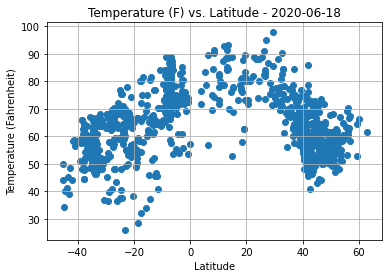

In [25]:
# Temperature (F) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["temperature"],
    "o",
    "Temperature (F) vs. Latitude",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude"
)

There is a moderate non-linear association between temperature and latitude. There seems to be some outliers.

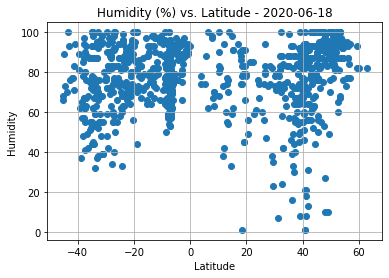

In [26]:
# Humidity (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["humidity"],
    "o",
    "Humidity (%) vs. Latitude",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude"
)

There is almost zero correlation between humidy and latitude. There are many outliers and the relation is non-linear.

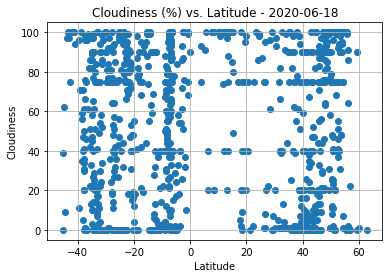

In [27]:
# Cloudiness (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude"
)

There is no correlation between cloudiness and latitude.

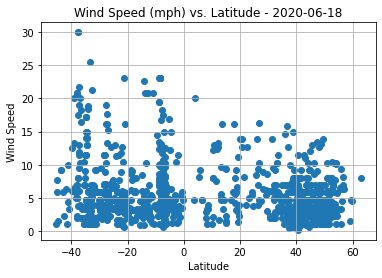

In [28]:
# Wind Speed (mph) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude"
)

There is almost zero correlation between wind speed and latitude. The little relation there is kind of non-linear with many outliers.

### Linear regression by Hemisphere

In [29]:
# Divide cities by hemispheres

northern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] > 0]
southern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] < 0]


The r-squared is: 0.4856368917426093


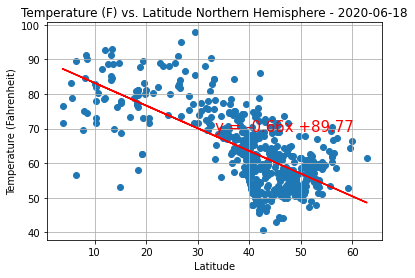

The r-squared is: 0.4401183855264538


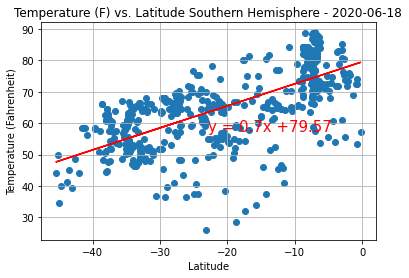

In [30]:
# Perform a linear regression on temperature vs. latitude for the northern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Northern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on temperature vs. latitude for the southern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Southern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-SH",
    regress_values,
    line_eq
)


On the northern hemisphere there seems to be a moderately strong, negative, linear association between the temperature and latitude with many outliers. The r-value tells a different story, because it tells there is almost no correlation between these variables.

On the southern hemisphere there seems to be a moderately strong, positive, linear association between the temperature and latitude with many outliers. The r-value slightly confirms this correlation.


The r-squared is: 0.08111974939279992


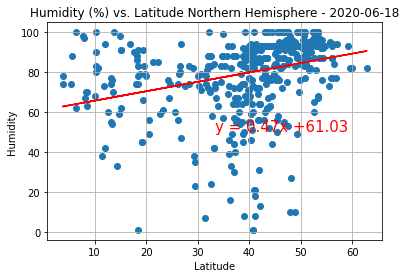

The r-squared is: 0.03294524219408177


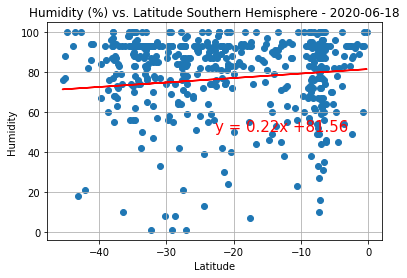

In [31]:
# Perform a linear regression on Humidity (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Northern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Humidity (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Southern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-SH",
    regress_values,
    line_eq
)

In both the northern and the southern hemispheres there is no correlation between humidity and latitude. The r-value for both plots confirms that there is no relation.

The r-squared is: 0.002256919323180203


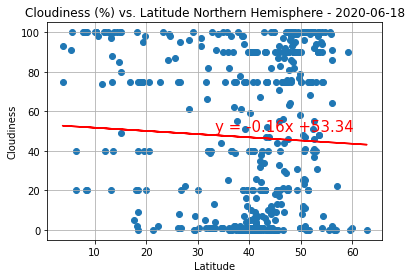

The r-squared is: 0.012179835810879726


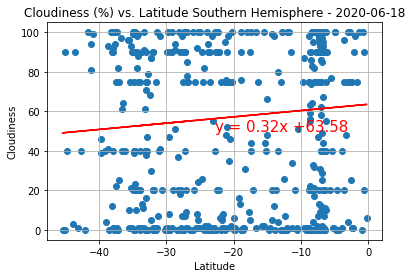

In [32]:
# Perform a linear regression on Cloudiness (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Northern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Cloudiness (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Southern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-SH",
    regress_values,
    line_eq
)

In both the northern and the southern hemispheres there is no correlation between cloudiness and latitude. The r-value for both plots confirms that there is no relation.


The r-squared is: 0.05860725320287874


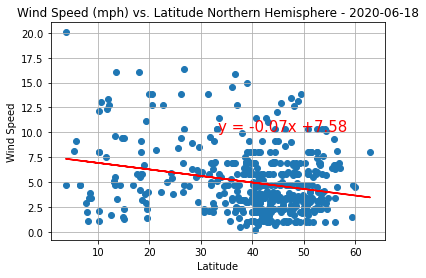

The r-squared is: 0.00965567097237694


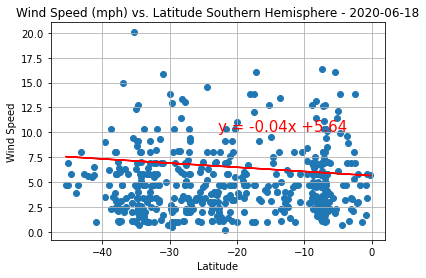

In [33]:
# Perform a linear regression on Wind Speed (mph) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Northern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Wind Speed (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Southern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-SH",
    regress_values,
    line_eq
)

In both the northern and the southern hemispheres there is no correlation between wind speed and latitude. The r-value for both plots confirms that there is no relation.